In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import wandb

# Params
Image.MAX_IMAGE_PIXELS = 1e11
CFG = {
    'base_model': 'resnet18',   # resnet18/34/50, efficientnet_v2_s/m/l
    'batch_size': 32,
    'whole_img_size': 700,
    'aug_img_size': 512,
    'aug_min_scale': 1.0,
    'freeze_epochs': 1,
    'epochs': 10,
    'seed': 42,
    'tissuecrop': False
}

# Wandb
wandb.login(key='1b0401db7513303bdea77fb070097f9d2850cf3b')
run = wandb.init(project='kaggle-ubc-ocean', config=CFG, tags=['fastai', 'baseline'])

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_filename = 'train.csv'
train_img_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')

# Functions
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_file_path(image_id):
    if os.path.exists(os.path.join(train_thumbnail_dir, f'{image_id}_thumbnail.png')):
        return os.path.join(train_thumbnail_dir, f'{image_id}_thumbnail.png')
    else:
        return os.path.join(train_img_dir, f'{image_id}.png')

# Seed
seed_everything(CFG['seed'])
torch.backends.cudnn.benchmark = True

# Load descriptive data
df = pd.read_csv(os.path.join(data_dir, train_filename))

# Add image path
df['image_path'] = df['image_id'].apply(get_file_path)
df

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: naraiadam88. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/latlab/.netrc


,image_id,label,image_width,image_height,is_tma,image_path
0,4,HGSC,23785,20008,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/4_thumbnail.png
1,66,LGSC,48871,48195,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/66_thumbnail.png
2,91,HGSC,3388,3388,True,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/91.png
3,281,LGSC,42309,15545,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/281_thumbnail.png
4,286,EC,37204,30020,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/286_thumbnail.png
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/65022_thumbnail.png
534,65094,MC,55042,45080,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/65094_thumbnail.png
535,65300,HGSC,75860,27503,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/65300_thumbnail.png
536,65371,HGSC,42551,41800,False,/media/latlab/MR/projects/kaggle-ubc-ocean/data/train_thumbnails/65371_thumbnail.png


In [2]:
class SideCrop(Transform):
    def __init__(self): pass
    def encodes(self, image: PILImage):
        size = min(image.size)
        new_image = image.crop_pad((size, size), (0,0))
        return new_image
    
class TissueCrop(Transform):
    def __init__(self, size): self.size = size
    def encodes(self, image: PILImage):
        h_sum = np.array(image).mean(2).sum(0)
        v_sum = np.array(image).mean(2).sum(1)

        if h_sum[0] != 0:
            h_left = 0
        else:
            h_left = np.where(h_sum==0)[0][0]
        if sum(h_sum[h_left:]==0) == 0:
            h_right = len(h_sum)
        else:
            h_right = np.where(h_sum[h_left:]==0)[0][0] + h_left

        if v_sum[0] != 0:
            v_top = 0
        else:
            v_top = np.where(v_sum==0)[0][0]
        if sum(v_sum[v_top:]==0) == 0:
            v_bottom = len(v_sum)
        else:
            v_bottom = np.where(v_sum[v_top:]==0)[0][-1] + v_top
        
        h_center = round((h_left + h_right)/2)
        v_center = round((v_top + v_bottom)/2)
        new_image = image.crop_pad((self.size, self.size), (h_center-round(self.size/2), v_center-round(self.size/2)))
        return new_image

if CFG['tissuecrop']:
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_x=ColReader('image_path'),
                get_y=ColReader('label'),
                splitter=RandomSplitter(valid_pct=0.2, seed=CFG['seed']),
                item_tfms=[TissueCrop(CFG['whole_img_size'])],
                batch_tfms=[*aug_transforms(size=CFG['aug_img_size'], min_scale=CFG['aug_min_scale'], max_warp=0), Normalize.from_stats(*imagenet_stats)])
else:
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
            get_x=ColReader('image_path'),
            get_y=ColReader('label'),
            splitter=RandomSplitter(valid_pct=0.2, seed=CFG['seed']),
            item_tfms=[SideCrop(), Resize(CFG['whole_img_size'], method='crop')],
            batch_tfms=[*aug_transforms(size=CFG['aug_img_size'], min_scale=CFG['aug_min_scale'], max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [3]:
%%time
dls = dblock.dataloaders(df, bs=CFG['batch_size'], num_workers=36)

CPU times: user 579 ms, sys: 97.6 ms, total: 677 ms
Wall time: 464 ms


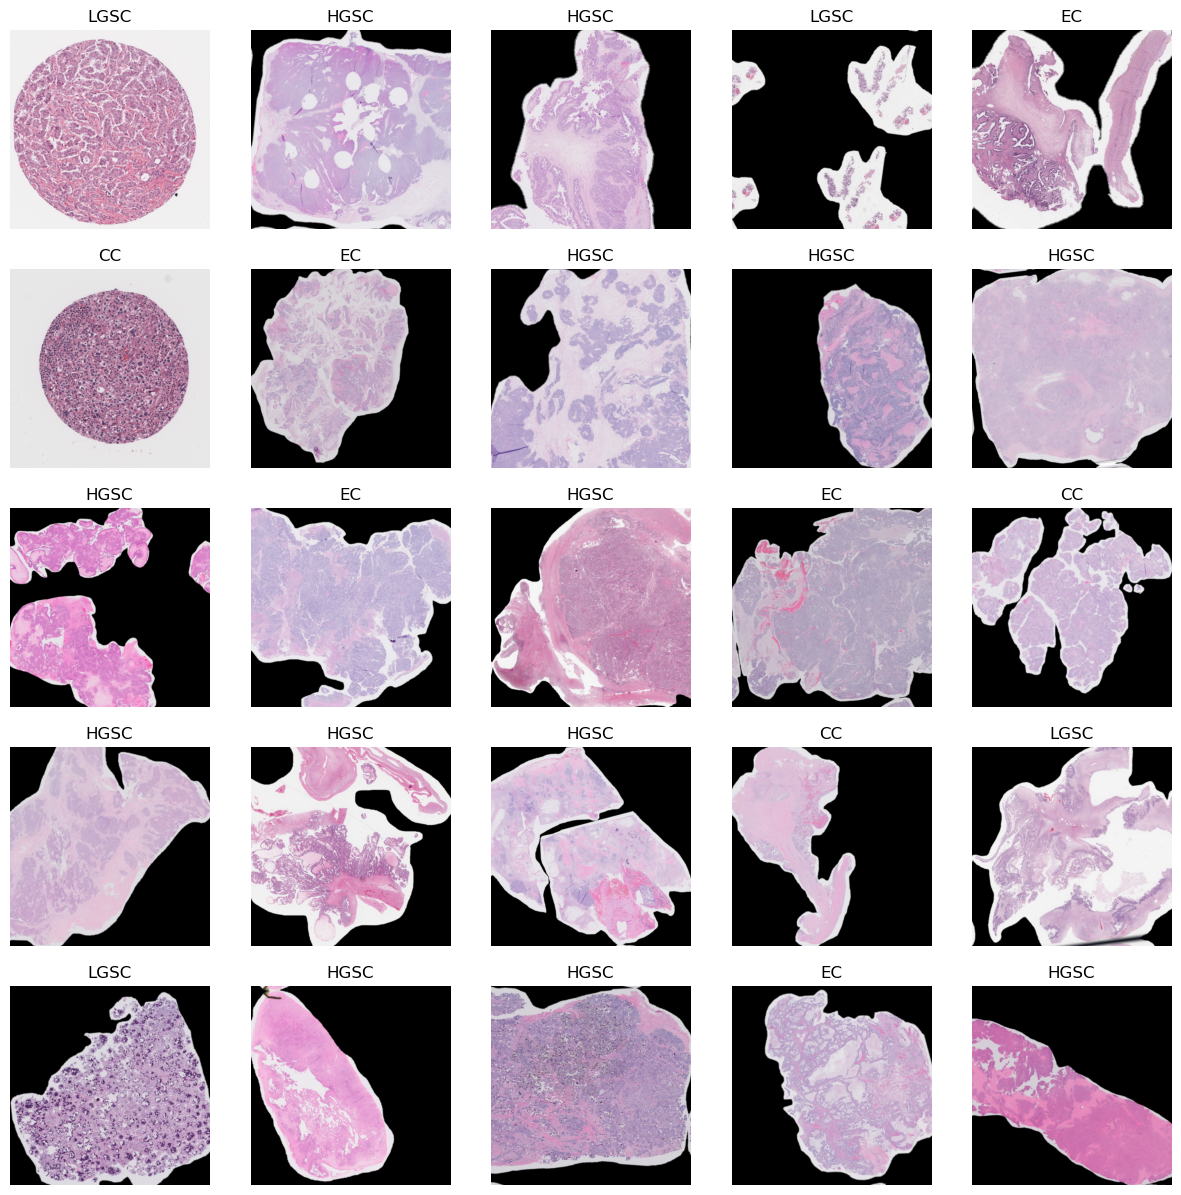

In [4]:
dls.show_batch(max_n=25)

In [5]:
learn = vision_learner(dls, eval(CFG['base_model']), metrics=BalancedAccuracy())
learn.fine_tune(CFG['epochs'], freeze_epochs=CFG['freeze_epochs'])

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,2.525243,1.580564,0.341818,00:17


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.905291,1.378668,0.480909,00:16
1,1.696244,1.286645,0.505455,00:17
2,1.502980,1.292581,0.536364,00:16
3,1.328704,1.339828,0.541818,00:16
4,1.152038,1.263566,0.573636,00:16
5,1.000246,1.119705,0.583636,00:17
6,0.904827,1.049031,0.645455,00:16
7,0.792289,1.047743,0.644545,00:16
8,0.714611,1.052493,0.615455,00:17
9,0.655715,1.039053,0.615455,00:16


In [6]:
for res in learn.recorder.values:
    wandb.log({'train_loss': res[0], 
               'valid_loss': res[1],
               'balanced_accuracy': res[2]})
wandb.finish()
learn.export(os.path.join(results_dir, 'models', f'ubc-ocean_{run.name}.pkl'))

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


balanced_accuracy,▁▂▃▄▅▅██▇▇
train_loss,█▇▆▅▄▃▂▂▁▁
valid_loss,█▆▆▇▆▃▁▁▁▁
balanced_accuracy,0.61545
train_loss,0.65572
valid_loss,1.03905


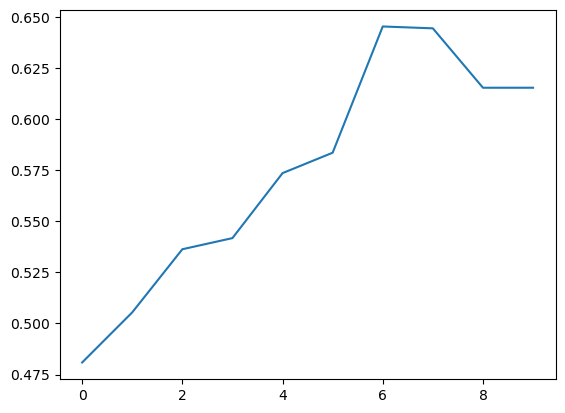

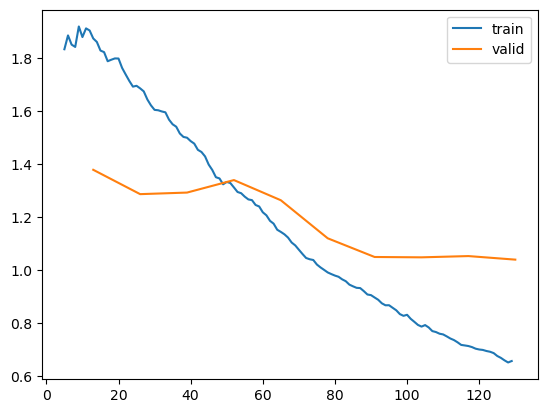

In [7]:
# Show accuracy plot
plt.plot(np.array(learn.recorder.values)[:,2])
plt.figure()
learn.recorder.plot_loss()

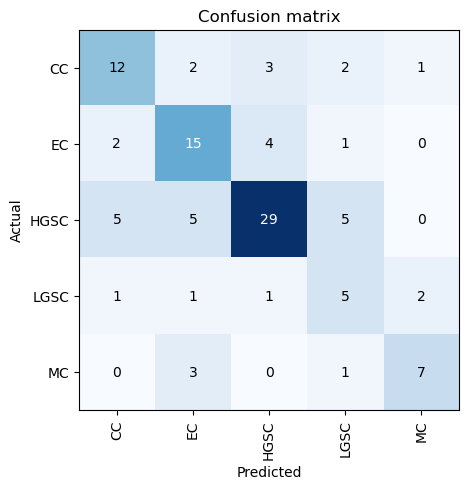

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
# interp.most_confused(min_val=5)

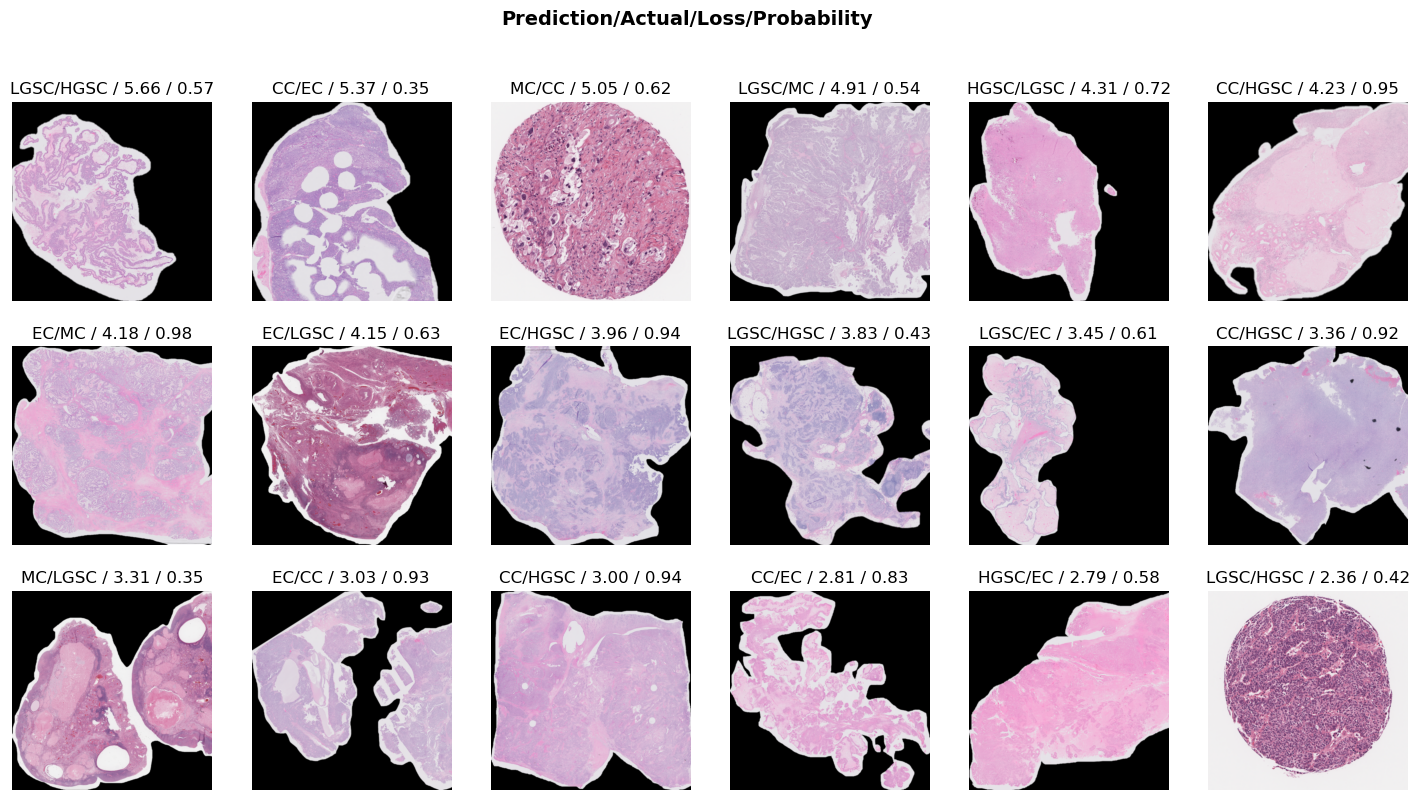

In [9]:
interp.plot_top_losses(18, nrows=3)